### Import necessary dependencies

In [1]:
import torch 
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn, save, load
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import functional as F
from torchsummary import summary


c:\Users\envy 12th\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define Hyperparameters

In [2]:
EPOCHS = 15
BATHC_SIZE = 32

### Load the dataset

In [4]:
train = datasets.ImageFolder(root="dataset/training_data", transform=ToTensor())
dataset = DataLoader(train, batch_size=32, shuffle=True)
print(f"Data loaded: {dataset.dataset} ")

Data loaded: Dataset ImageFolder
    Number of datapoints: 30106
    Root location: dataset/training_data
    StandardTransform
Transform: ToTensor() 


### Split the data into training and test data

The data contains images for the majer 34 amharic characters ranging from ሀ to ፐ. The folder structure is as follows:

- dataset
    - ሀ
        - img1.jpg
        - img2.jpg
        .
        .
        .
    - ለ
        - img1.jpg
        - img2.jpg
        .
        .
        .
    .
    .
    .
    .

We need to divide this data into training and testing set with a ration of 80:20. This allows us to train the model on the 80% of the data and test it on the remaining unseen 20% of the data.



I used this code to split my dataset into training and test data. NO NEED TO RUN THIS BLOCK OF CODE SINCE THE DATA IS ALREADY BEEN RAN ONCE AND IT'S SPLITTED INTO THE DESIRED TRAINING AND TEST DATA.

In [4]:
# # DO NOT RUN THE CODE BELOW.
# import os
# import random
# import shutil

# # Set the path to your dataset
# dataset_path = "data_copy"

# # Set the path to the training and test data folders
# training_data_path = "training_data"
# test_data_path = "test_data"

# # Set the ratio for splitting the data (80% for training, 20% for testing)
# split_ratio = 0.8

# # Create the training and test data folders if they don't exist
# os.makedirs(training_data_path, exist_ok=True)
# os.makedirs(test_data_path, exist_ok=True)

# # Iterate through the characters in the dataset
# for char_folder in os.listdir(dataset_path):
#     char_folder_path = os.path.join(dataset_path, char_folder)
#     if os.path.isdir(char_folder_path):
#         # Get the list of image files in the character folder
#         image_files = os.listdir(char_folder_path)

#         # Shuffle the image files randomly
#         random.shuffle(image_files)

#         # Calculate the split index based on the split ratio
#         split_index = int(len(image_files) * split_ratio)

#         # Split the image files into training and test data
#         training_files = image_files[:split_index]
#         test_files = image_files[split_index:]

#         # Move the training files to the training data folder
#         for file in training_files:
#             src = os.path.join(char_folder_path, file)
#             dst = os.path.join(training_data_path, char_folder, file)
#             os.makedirs(os.path.dirname(dst), exist_ok=True)
#             shutil.move(src, dst)

#         # Move the test files to the test data folder
#         for file in test_files:
#             src = os.path.join(char_folder_path, file)
#             dst = os.path.join(test_data_path, char_folder, file)
#             os.makedirs(os.path.dirname(dst), exist_ok=True)
#             shutil.move(src, dst)

### Define the image classifier Neural Network

#### Here is the structure of the neural network.

1. Input Layer:

    - The input to the network is expected to have 3 channels (e.g., for RGB images).

2. Convolutional Layers:

    - nn.Conv2d(3, 32, (3,3)) defines the first convolutional layer with 3 input channels, 32 output channels, and a 3x3 kernel size.
    - nn.ReLU() applies the Rectified Linear Unit activation function to introduce non-linearity after the first convolutional layer.
    - nn.Conv2d(32, 64, (3,3)) defines the second convolutional layer with 32 input channels (from the previous layer), 64 output channels, and a 3x3 kernel size.
    - nn.ReLU() applies the ReLU activation function after the second convolutional layer.
    - nn.Conv2d(64, 64, (3,3)) defines the third convolutional layer with 64 input channels, 64 output channels, and a 3x3 kernel size.
    - nn.ReLU() applies the ReLU activation function after the third convolutional layer.

3. Flatten Layer:

    - nn.Flatten() flattens the output of the previous layer into a 1D tensor. This is done to transform the 2D feature maps into a 1D vector for the subsequent fully connected layers.

4. Fully Connected Layer:

    - nn.Linear(64*(28-6)*(28-6), 34) defines a fully connected layer with input size determined by the number of channels from the previous layer (64) and the spatial dimensions of the feature maps (28-6)*(28-6).
    - The output size of this layer is set to 34, which suggests that the network is designed to classify inputs into 34 different classes which are the 34 Amharic based characters.

In [5]:
class ImageClassifier(nn.Module): 
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, (3,3)), 
            nn.ReLU(),
            nn.Conv2d(32, 64, (3,3)), 
            nn.ReLU(),
            nn.Conv2d(64, 64, (3,3)), 
            nn.ReLU(),
            nn.Flatten(), 
            nn.Linear(64*(28-6)*(28-6), 34)  
        )

    def forward(self, x): 
        return self.model(x)

### Instance of the neural network, loss, optimizer 


In [6]:
clf = ImageClassifier().to('cpu')
opt = Adam(clf.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss() 

summary(clf, input_size=(3, 28, 28)) # Show the summary of the model layers

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             896
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
              ReLU-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 22, 22]          36,928
              ReLU-6           [-1, 64, 22, 22]               0
           Flatten-7                [-1, 30976]               0
            Linear-8                   [-1, 34]       1,053,218
Total params: 1,109,538
Trainable params: 1,109,538
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.60
Params size (MB): 4.23
Estimated Total Size (MB): 5.84
----------------------------------------------------------------


### Training flow 

- I trained the model for 15 epochs and printed the loss at each stage.

In [7]:
loss_at_each_epoch = []

for epoch in range(EPOCHS): # train for 15 epochs
    for batch in dataset: 
        X,y = batch 
        X, y = X.to('cpu'), y.to('cpu') 
        yhat = clf(X) 
        loss = loss_fn(yhat, y) 

        # Apply backprop 
        opt.zero_grad()
        loss.backward() 
        opt.step() 

    loss_at_each_epoch.append(loss.item())
    print(f"Epoch:{epoch} loss is {loss.item()}")

with open('trained_model.pt', 'wb') as f: 
    save(clf.state_dict(), f) 

Epoch:0 loss is 0.7817431092262268
Epoch:1 loss is 0.2882244884967804
Epoch:2 loss is 0.37115147709846497
Epoch:3 loss is 0.37258073687553406
Epoch:4 loss is 0.04359891638159752
Epoch:5 loss is 0.14385566115379333
Epoch:6 loss is 0.16663500666618347
Epoch:7 loss is 0.054139312356710434
Epoch:8 loss is 0.040572211146354675
Epoch:9 loss is 0.013952912762761116
Epoch:10 loss is 0.009447433985769749
Epoch:11 loss is 0.0557887926697731
Epoch:12 loss is 0.006024363450706005
Epoch:13 loss is 0.03646283596754074
Epoch:14 loss is 0.0011436213972046971


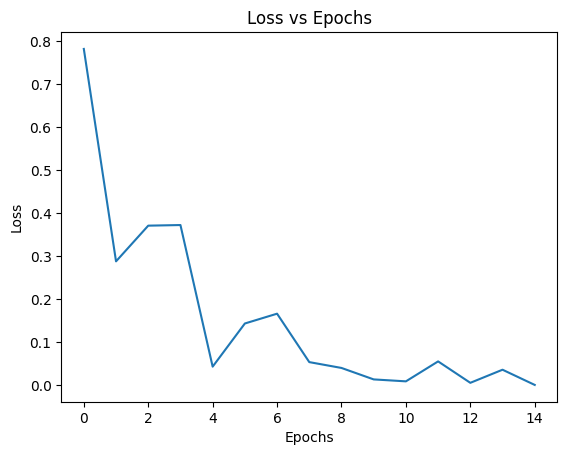

In [10]:
# Plot loss vs epoch graph.
epochs = list(range(EPOCHS))
plt.plot(epochs, loss_at_each_epoch)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()

## Testing the trained model

### Load the model

In [11]:
with open('trained_model.pt', 'rb') as f: 
    clf.load_state_dict(load(f)) 

In [12]:
# Get test data
test = datasets.ImageFolder(root="dataset/test_data", transform=ToTensor())
test_dataset = DataLoader(test, batch_size=32, shuffle=False)

# Evaluation loop
clf.eval()  # Set model to evaluation mode
test_loss = 0
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculation
    for batch in test_dataset:
        X, y = batch
        X, y = X.to('cpu'), y.to('cpu')
        yhat = clf(X)
        test_loss += loss_fn(yhat, y).item()
        predicted = yhat.argmax(dim=1, keepdim=True)
        total += y.size(0)
        correct += predicted.eq(y.view_as(predicted)).sum().item()
    

# Calculate Loss and Accuracy
total_dataset = len(test_dataset.dataset)
test_loss /= total_dataset

accuracy = (correct / total) * 100

print(f"Test Loss: {test_loss:.4f}")
print(f"Accuracy: {accuracy:.2f}%")

Test Loss: 0.0362
Accuracy: 83.85%


### Load a sample image

In [13]:
img = Image.open('ቀ.jpg')
img.convert('RGB')
img_tensor = F.to_tensor(img)
img_tensor = img_tensor.unsqueeze(0)
img_tensor = img_tensor.expand(3, 3, img_tensor.shape[2], img_tensor.shape[3])

amharic_chars = ['ሀ', 'ለ', 'ሐ', 'መ', 'ሠ', 'ረ', 'ሰ', 'ሸ', 'ቀ', 'በ', 'ቨ', 'ተ', 'ቸ', 'ኀ', 'ነ', 'ኘ', 'አ', 'ከ', 'ኸ', 'ወ', 'ዐ', 'ዘ', 'ዠ', 'የ', 'ደ', 'ጀ', 'ገ', 'ጠ', 'ጨ', 'ጰ', 'ጸ', 'ፀ', 'ፈ', 'ፐ']

predicted_character_index = torch.argmax(clf(img_tensor))
predicted_character = amharic_chars[predicted_character_index]
print(f"The predicted character is {predicted_character}")

The predicted character is ቀ
